# Develop/test confusion matrix code for spectral types [v0.1]

In [38]:
%matplotlib notebook

In [39]:
# imports
import numpy as np
from matplotlib import pyplot as plt

from astropy.table import Table
from desisim.spec_qa.redshifts import match_truth_z

## Load Tables

In [3]:
path = '/scratch/DESI_SCRATCH/18.3/'

In [4]:
simz_tab = Table.read(path+'truth.fits')

In [5]:
zb_tab = Table.read(path+'zcatalog-mini.fits')

## Match

In [6]:
match_truth_z(simz_tab, zb_tab, mini_read=True)

INFO: Upgrading Table to masked Table. Use Table.filled() to convert to unmasked table. [astropy.table.table]


## Now what?

In [8]:
simz_tab

TARGETID,MOCKID,CONTAM_TARGET,TRUEZ,TRUESPECTYPE,TEMPLATETYPE,TEMPLATESUBTYPE,TEMPLATEID,SEED,MAG,VDISP,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,OIIFLUX,HBETAFLUX,TEFF,LOGG,FEH,Z,ZERR,ZWARN,SPECTYPE,DESI_TARGET
int64,int64,int64,float32,str10,str10,str10,int32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,int64,str6,int64
288230398217945088,15594312,0,0.134829,GALAXY,BGS,,3627,1482857632,19.8104,61.5363,5.24496,13.0271,22.0723,17.0456,11.0778,-1.0,0.0,-1.0,-1.0,-1.0,--,--,--,--,--
288230398217945089,19713506,0,0.131031,GALAXY,BGS,,3100,1847516324,18.5536,61.5363,23.2365,39.1643,57.4299,52.1437,38.0304,-1.0,1.62485e-15,-1.0,-1.0,-1.0,--,--,--,--,--
288230398217945090,17928726,0,0.145801,GALAXY,BGS,,1281,1159188526,18.3514,61.5363,19.8501,50.1084,86.5181,74.6362,51.4383,-1.0,0.0,-1.0,-1.0,-1.0,--,--,--,--,--
288230398217945091,19762079,0,0.295097,GALAXY,BGS,,5168,1664239784,17.9932,61.5363,18.4524,71.9985,149.989,178.462,126.497,-1.0,0.0,-1.0,-1.0,-1.0,--,--,--,--,--
288230398217945092,13979089,0,0.404595,GALAXY,BGS,,6077,236582212,20.1547,61.5363,2.09978,9.95809,21.8389,36.396,28.0412,-1.0,0.0,-1.0,-1.0,-1.0,--,--,--,--,--
288230398217945093,16459200,0,0.264106,GALAXY,BGS,,1126,1991162537,19.1176,61.5363,11.3866,23.7894,35.4239,33.6405,26.4355,-1.0,6.34972e-16,-1.0,-1.0,-1.0,--,--,--,--,--
288230398217945094,18522434,0,0.124415,GALAXY,BGS,,5431,266394818,18.6124,61.5363,15.305,39.5149,73.9385,79.3565,54.7434,-1.0,1.20094e-16,-1.0,-1.0,-1.0,--,--,--,--,--
288230398217945095,17843316,0,0.32049,GALAXY,BGS,,891,465634076,19.9593,61.5363,3.73762,11.398,21.8683,27.3294,20.5494,-1.0,8.81773e-17,-1.0,-1.0,-1.0,--,--,--,--,--
288230398217945096,16440187,0,0.294273,GALAXY,BGS,,3795,1715747948,18.0603,61.5363,16.0364,68.1686,149.188,206.879,152.196,-1.0,0.0,-1.0,-1.0,-1.0,--,--,--,--,--


In [11]:
np.unique(simz_tab['ZWARN'])

0
4
32
36
1024
1028
--


In [16]:
measured_z = simz_tab['ZWARN'].mask == False
np.unique(simz_tab[measured_z]['SPECTYPE']), np.unique(simz_tab[measured_z]['TRUESPECTYPE'])

(<MaskedColumn name='SPECTYPE' dtype='str6' length=3>
 GALAXY
 QSO   
 STAR  , <MaskedColumn name='TRUESPECTYPE' dtype='str10' length=4>
 GALAXY    
 QSO       
 STAR      
 WD        )

## Confuse me

In [18]:
# Cut the table
cut_simz = simz_tab[measured_z]

In [27]:
# Strip those columns
strip_ttypes = np.char.rstrip(cut_simz['TRUESPECTYPE'])
strip_stypes = np.char.rstrip(cut_simz['SPECTYPE'])

In [29]:
# All TRUE types
ttypes = np.unique(strip_ttypes)
ttypes

array(['GALAXY', 'QSO', 'STAR', 'WD'], 
      dtype='<U10')

In [30]:
# All SPEC types
stypes = np.unique(strip_stypes)
stypes

array(['GALAXY', 'QSO', 'STAR'], 
      dtype='<U6')

In [31]:
# Init
results = {}
for ttype in ttypes:
    results[ttype] = {}

In [36]:
for ttype in ttypes:
    itrue = strip_ttypes == ttype
    # Init correct answer in case there are none
    results[ttype][ttype] = 0
    #import pdb; pdb.set_trace()
    for stype in stypes:
        results[ttype][stype] = np.sum(strip_stypes[itrue] == stype)

In [37]:
results

{'GALAXY': {'GALAXY': 34736, 'QSO': 2, 'STAR': 0},
 'QSO': {'GALAXY': 17, 'QSO': 3388, 'STAR': 0},
 'STAR': {'GALAXY': 521, 'QSO': 0, 'STAR': 2271},
 'WD': {'GALAXY': 7, 'QSO': 0, 'STAR': 71, 'WD': 0}}

## Plot

### Build the matrix

In [53]:
confuse = np.zeros((ttypes.size, ttypes.size))

In [54]:
for ii,ttype in enumerate(ttypes):
    for jj,ottype in enumerate(ttypes):
        if ottype in results[ttype].keys():
            confuse[ii,jj] = results[ttype][ottype]
confuse

array([[  3.47360000e+04,   2.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  1.70000000e+01,   3.38800000e+03,   0.00000000e+00,
          0.00000000e+00],
       [  5.21000000e+02,   0.00000000e+00,   2.27100000e+03,
          0.00000000e+00],
       [  7.00000000e+00,   0.00000000e+00,   7.10000000e+01,
          0.00000000e+00]])

### Normalize

In [55]:
for kk in range(confuse.shape[0]):
    confuse[kk,:] /= np.sum(confuse[kk,:])
confuse

array([[  9.99942426e-01,   5.75738384e-05,   0.00000000e+00,
          0.00000000e+00],
       [  4.99265786e-03,   9.95007342e-01,   0.00000000e+00,
          0.00000000e+00],
       [  1.86604585e-01,   0.00000000e+00,   8.13395415e-01,
          0.00000000e+00],
       [  8.97435897e-02,   0.00000000e+00,   9.10256410e-01,
          0.00000000e+00]])

### Plot

<IPython.core.display.Javascript object>


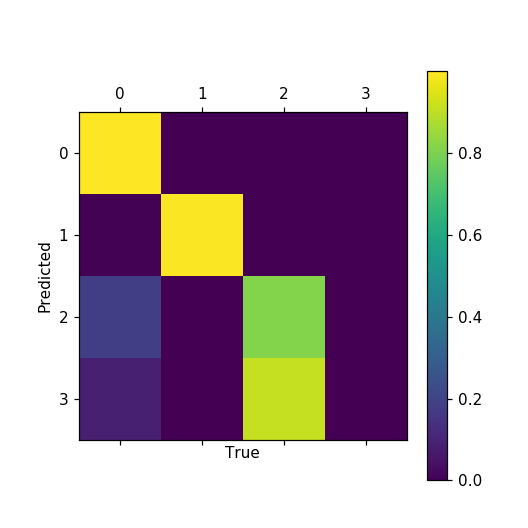

In [60]:
#plt.clf()
plt.matshow(confuse)
plt.colorbar()
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()